In [20]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Image, Audio

# 0. DFT (Discrete Fourier Transform)
- **Fourier analysis는 어떤 신호 xs를 Fourier series(서로 다른 주기를 가지는 정현파 신호들을의 합)로 표현(혹은 근사) 하는 것을 뜻한다.**
- **Fourier series의 각 주기의 Coeffiecient를 구하는 방법을 Fourier Transform 이라고 한다.**
- **DFT는 Discrete 신호의 제한된 범위에 대한 Fourier Transform을 뜻한다**

DFT : $$ X[k] = \sum^{N-1}_{n=0} x[n] e^{-j\frac{2\pi}{N}kn }$$

iDFT : $$ x[k] =\frac{1}{N} \sum^{N-1}_{n=0} X[n] e^{j\frac{2\pi}{N}kn } $$

In [21]:
# DFT implementation using python
def dft(xs):
    N = len(xs)
    Xs = np.zeros((N,), dtype=np.complex)
    for k in range(N):
        Xs[k] = sum(xs[n]*np.exp(-2j * np.pi * k * n / N) for n in range(N))
    return Xs

def idft(Xs):
    return np.array([sum((Xs[n] * np.exp(2j * np.pi * k * n / N) for n in range(N)))/N for k in range(N)])

## 0.1 DFT example

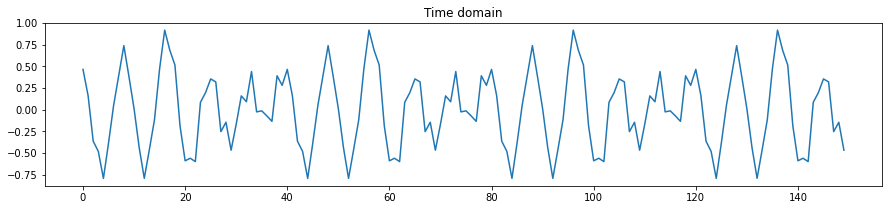

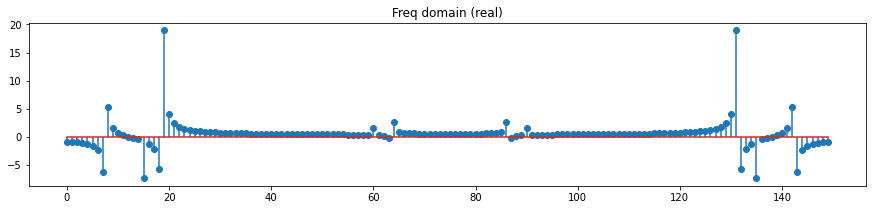

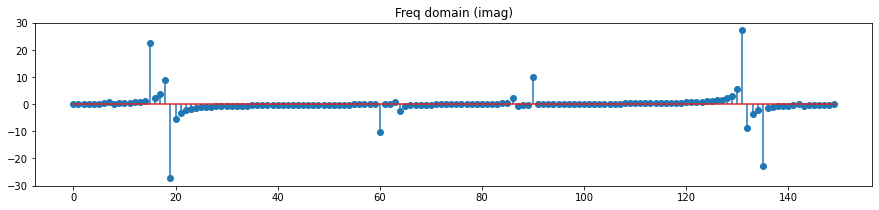

In [22]:
def x(n):
    xs = 0.1223*np.cos(0.1*np.pi*n + 1.5077)+\
    0.2942*np.cos(0.2*np.pi*n + 1.8769)+\
    0.4884*np.cos(0.25*np.pi*n - 0.1852)+\
    0.1362*np.cos(0.8*np.pi*n - 1.4488)+\
    0.0472*np.cos(0.85*np.pi*n)
    return xs

xs = x(np.arange(0, 150))

plt.figure(figsize=(15,3))
plt.title('Time domain')
plt.plot(xs)
plt.show()

Xs = dft(xs)
plt.figure(figsize=(15,3))
plt.title('Freq domain (real)')
plt.stem(Xs.real)
plt.show()

plt.figure(figsize=(15,3))
plt.title('Freq domain (imag)')
plt.stem(Xs.imag)
plt.show()

# 1. STFT and spectrogram

- **STFT는 시간에 따른 local section의 signal frequency와 phase를 보기위해 사용한다.**
- **Window가 움직이며 각 영역에 대한 DFT의 결과를 계산한다.**
- **Window에 kernel(혹은 filter box)를 씌워, 그 결과에 대한 DFT를 계산하기도 한다.**


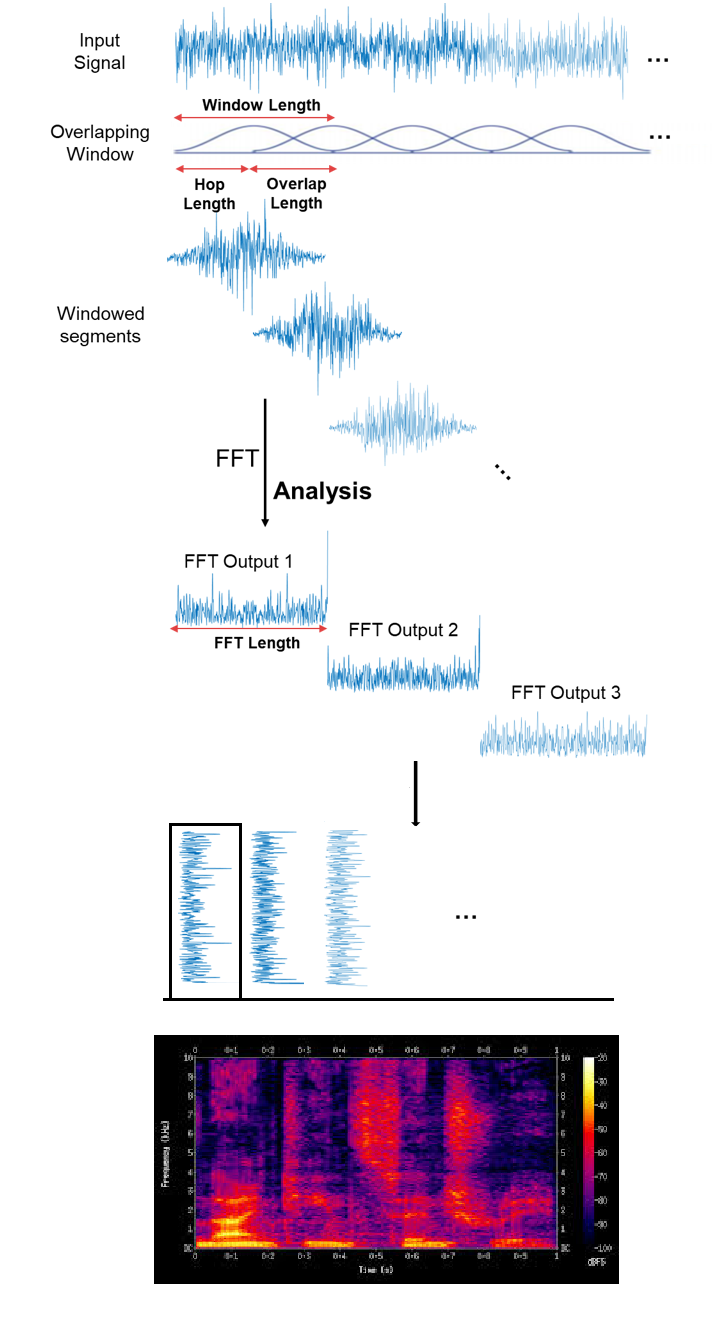

In [23]:
Image("img/01.png")
# Image from mathworks

---
## 1.1 STFT example

c:\users\wlstj\.conda\envs\dsp\lib\site-packages\librosa\display.py:823: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  "Trying to display complex-valued input. " "Showing magnitude instead."


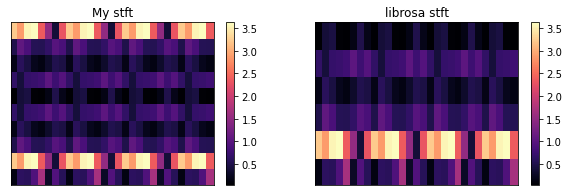

In [24]:
def stft(xs, window_size, hop_size):
    N = (len(xs)-window_size)//hop_size + 1
    Xs = np.zeros((N, window_size), dtype=np.complex)
    for n in range(N):
        xs_ = xs[n*hop_size:n*hop_size+window_size]
        Xs_ = dft(xs_)
        Xs[n] = Xs_
    return Xs.T

my_stft_result = stft(xs, 10, 5)
lib_stft_result2 = librosa.stft(xs, n_fft = 10, hop_length=5, window='boxcar', center=False)

plt.figure(figsize = (10,3))
plt.subplot(1,2,1)
librosa.display.specshow(my_stft_result, sr=10, hop_length=5)
plt.colorbar()
plt.title("My stft")

plt.subplot(1,2,2)
librosa.display.specshow(lib_stft_result2, sr=10, hop_length=5)
plt.colorbar()
plt.title("librosa stft")
plt.show()

결과가 조금 달라보이는데, dft의 결과는 magnitude가 좌우 대칭이므로 librosa는 절반만 보여주는 것 같다.

반을 때서 살펴보면, 거의 차이가 나지 않는다.

In [25]:
error = np.mean(np.mean(my_stft_result[:6,:] - lib_stft_result2))
print('error :', np.abs(error))

error : 5.411213802044208e-17


(원리는 알았으니 librosa를 쓰자...)

## 1.2 STFT example 2
- 현실 데이터를 가져와서 사용해보자.

(미드 friends의 한 부분)

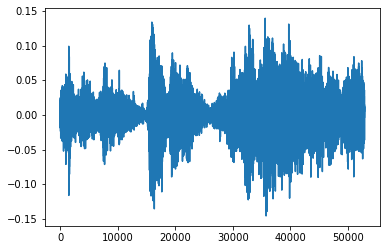

In [26]:
audio, sr = librosa.load('sample.wav')

# visualize
plt.plot(audio)
plt.show()

In [27]:
Audio(audio, rate=sr)

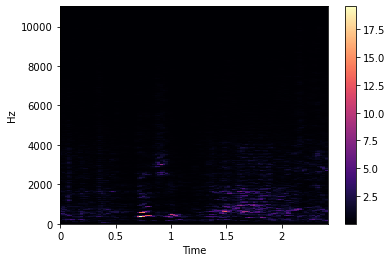

In [28]:
n_fft = 2048 # Q1. how i can choose?
stft_audio = librosa.stft(audio, n_fft=n_fft, hop_length=None)

# visualize
plt.figure()
librosa.display.specshow(np.abs(stft_audio), sr=sr,
                         x_axis = 'time',
                         y_axis = 'hz')
plt.colorbar()
plt.show()

너무 작아서 보이지 않는다...

사람의 목소리는 대부분 저음역대에 있으므로, 다음과 같이 나타난다.

그러므로, dB단위로 바꾸어 준다.
(Q2. 왜 dB? log scale중 의미있는 단위라서?)

(1025, 104)


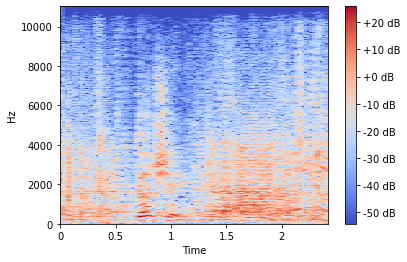

In [29]:
log_stft_audio = librosa.amplitude_to_db(np.abs(stft_audio))
print(log_stft_audio.shape)
# visualize
plt.figure()
librosa.display.specshow(log_stft_audio, sr=sr,
                         x_axis = 'time',
                         y_axis = 'hz')
plt.colorbar(format='%+2.0f dB')
plt.show()

---
# 2. Mel-spectrogram

사람은 높은 주파수 범위보다 낮은 주파수 범위에서 더 민감하다.

예를 들면, 500Hz와 1000Hz의 차이는 구분을 쉽게 하지만, 10000Hz와 10500Hz는 잘 구분을 하지 못한다.
사람이 듣는 소리를 기준으로, 소리(주파수)를 선형적으로 구분한 것을 **Mel scale** 이라고 한다.

**pitch in mels** $= 1127 log_e(1+F/700)$

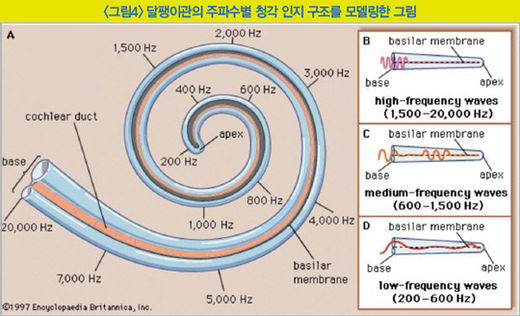

In [30]:
Image('img/02.png')

## 2.1 Mel filter bank

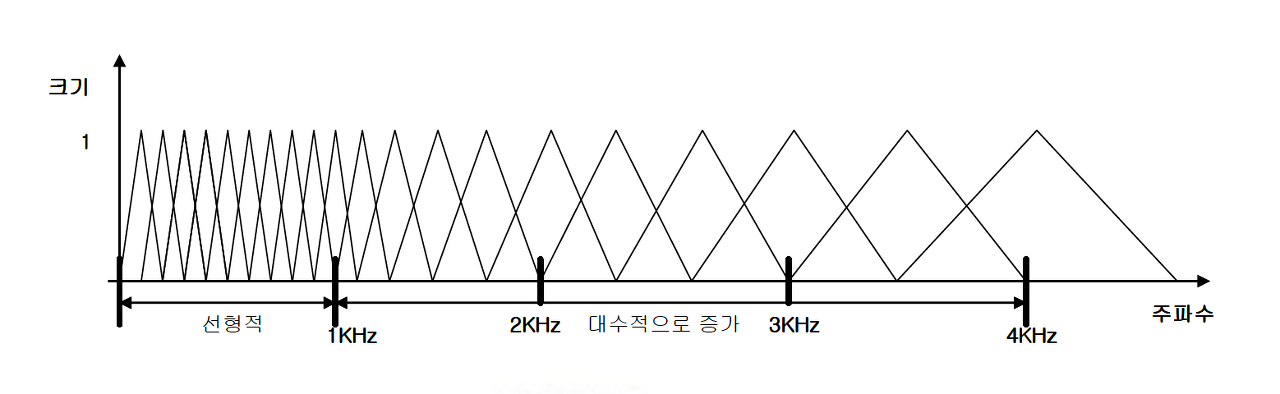

In [31]:
Image('img/03.png')

[[0.         0.01618285 0.03236571 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.00026052 0.00013026 0.        ]]


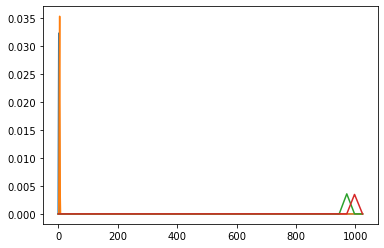

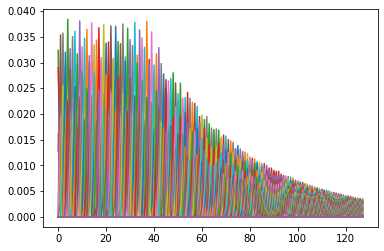

In [32]:
mel_filter_bank = librosa.filters.mel(sr=sr, n_fft=2048)
print(mel_filter_bank)
plt.plot(mel_filter_bank[0])
plt.plot(mel_filter_bank[1])
plt.plot(mel_filter_bank[-2])
plt.plot(mel_filter_bank[-1])
plt.show()

plt.plot(mel_filter_bank)
plt.show()

## 2.2 Mel spec example

(256, 104)


c:\users\wlstj\.conda\envs\dsp\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
c:\users\wlstj\.conda\envs\dsp\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


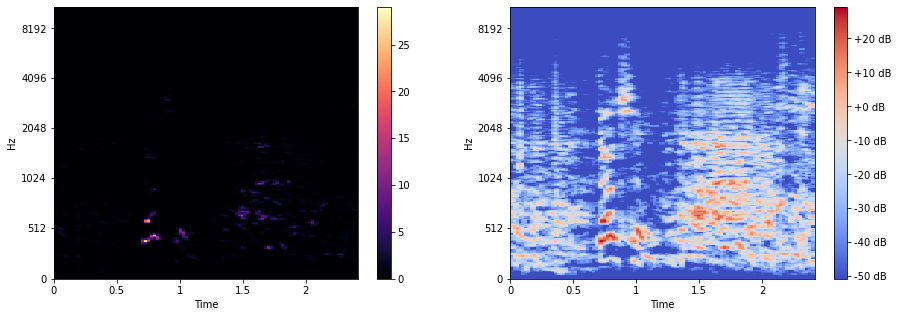

In [33]:
mel_spec_audio = librosa.feature.melspectrogram(audio,
                                                sr = sr,
                                                n_mels = 256,
                                                hop_length = None)
log_mel_spec_audio = librosa.amplitude_to_db(np.abs(mel_spec_audio))

# visualize
print(mel_spec_audio.shape)
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
librosa.display.specshow(mel_spec_audio,
                         x_axis = 'time',
                         y_axis = 'mel')
plt.colorbar()

plt.subplot(1,2,2)
librosa.display.specshow(log_mel_spec_audio,
                         x_axis = 'time',
                         y_axis= 'mel')
plt.colorbar(format='%+2.0f dB')

plt.show()

256개의 mel filter를 사용해서 output을 구성 했을때 예시..

---
# 3. MFCC (Mel-Frequency Cepstral Coefficient)

MFCC 추출 과정.

(잘모르겠다.)

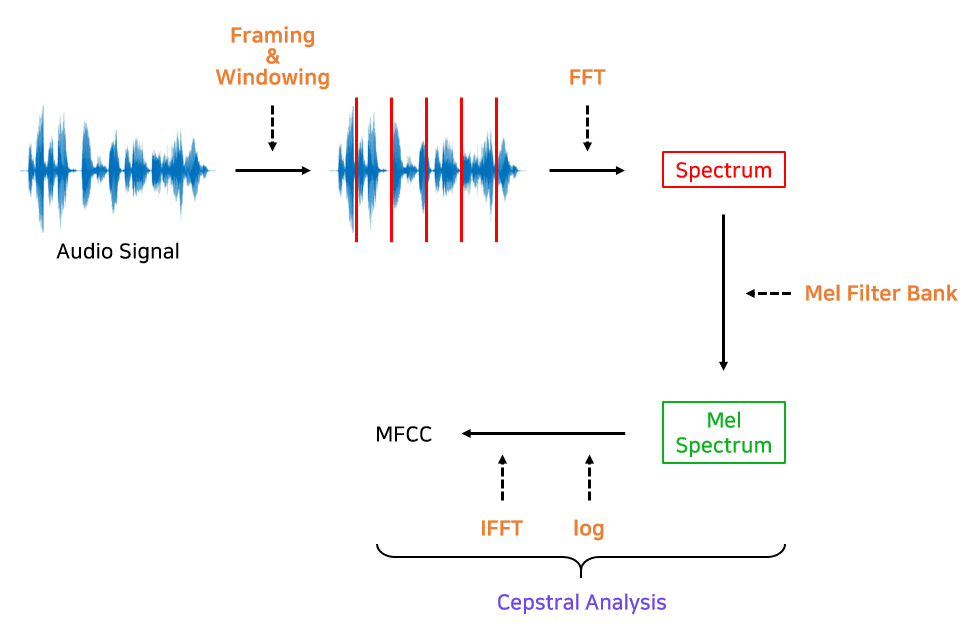

In [34]:
Image("img/04.png")

## 3.1 Cepstral analysis

악기 소리와 사람의 음성은 Harmonic(배음) 구조를 가지고 있다.

배음 구조란, 기본주파수(F0)와 기본주파수의 정배수인 Harmonics(배음)들로 구성된 소리를 뜻한다.
악기나, 성대에 따라 이러한 배음 구조가 달라지며 배음 구조의 차이에 따라 음색의 차이를 만들어 낸다.

이러한 기본 주파수(F0)를 찾기 위한 방법이 Cepstral(캡스트럴) 분석이다.

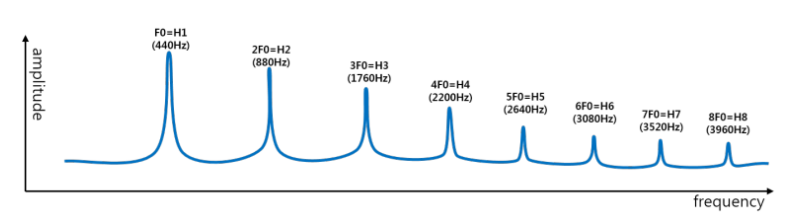

In [35]:
# Harmonic Image
Image("img/05.png")

Cepstral 분석의 방법은 간단하다.

Signal에 fft를 적용한 후, log를 씌워 다시 ifft를 적용한다.
그 결과에 대해, 저 주파수 부분의 가장 높은 peak부분의 값들을 기본 주파수 혹은 배음으로 생각하여
뽑아준다.


### 3.2 Cepstral analysis example

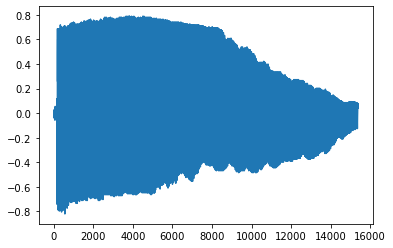

In [36]:
sol_audio, sol_sr = librosa.load("sol.wav")

plt.plot(sol_audio)
plt.show()

In [ ]:
Audio(sol_audio, rate=sol_sr)

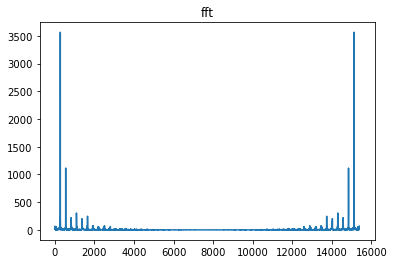

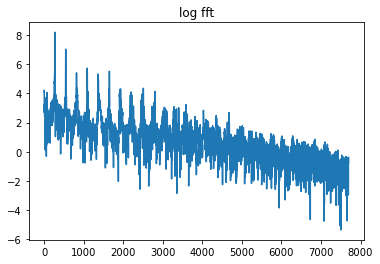

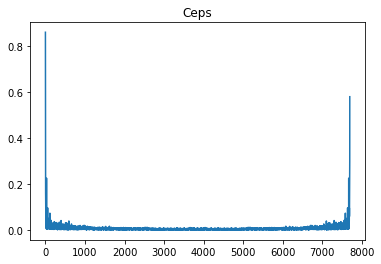

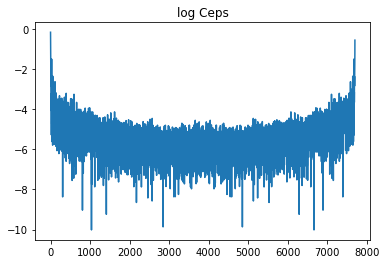

In [37]:
Xs = np.fft.fft(sol_audio)
plt.plot(np.abs(Xs))
plt.title('fft')
plt.show()

N = len(Xs)//2+1
log_Xs= np.log(np.abs(Xs[:N]))
plt.plot(log_Xs)
plt.title('log fft')
plt.show()

Ceps = np.fft.ifft(log_Xs)
plt.plot(np.abs(Ceps))
plt.title('Ceps')
plt.show()

plt.plot(np.log(np.abs(Ceps)))
plt.title('log Ceps')
plt.show()

## 3.2 MFCC

mfcc shape :  (20, 104)


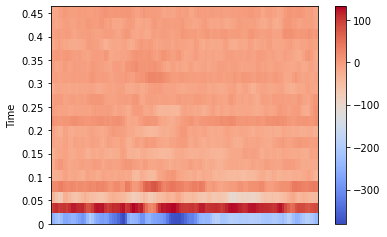

In [38]:
mfcc = librosa.feature.mfcc(audio, sr=sr, n_mfcc = 20)
print("mfcc shape : ",mfcc.shape)
librosa.display.specshow(mfcc, sr=sr,
                         y_axis = 'time')
plt.colorbar()
plt.show()

## ref
- mathworks
- https://hyunlee103.tistory.com/48?category=912459
- librosa document
- https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53